<a href="https://colab.research.google.com/github/GloriaMoraaRiechi/Spring-2025/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The examined group comprised kernels belonging to three different varieties of wheat: Kama, Rosa and Canadian, 70 elements each, randomly selected for the experiment. High quality visualization of the internal kernel structure was detected using a soft X-ray technique. It is non-destructive and considerably cheaper than other more sophisticated imaging techniques like scanning microscopy or laser technology. The images were recorded on 13x18 cm X-ray KODAK plates. Studies were conducted using combine harvested wheat grain originating from experimental fields, explored at the Institute of Agrophysics of the Polish Academy of Sciences in Lublin. The data set can be used for the tasks of classification and cluster analysis.

Attribute Information:To construct the data, seven geometric parameters of wheat kernels were measured:
1. area A,
2. perimeter P,
3. compactness C = 4*pi*A/P^2,
4. length of kernel,
5. width of kernel,
6. asymmetry coefficient
7. length of kernel groove.

All of these parameters were real-valued continuous.

Apply K-means clustering using PySpark in Google Colab based on the seed.txt dataset

Apply Gaussian Mixture Model with the same seed.txt dataset

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans, GaussianMixture
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col, sum

Initialize spark session

In [ ]:
spark = SparkSession.builder.appName("Clustering").getOrCreate()

Load dataset

In [ ]:
from google.colab import files

# Upload the file
uploaded = files.upload()

# Get the uploaded file name
file_name = list(uploaded.keys())[0]

# Read the file
data = spark.read.csv(file_name, header=False, inferSchema=True, sep="\t")


Saving seed.txt to seed (2).txt


In [ ]:
data.show(5)

+-----+-----+------+-----+-----+-----+-----+---+
|  _c0|  _c1|   _c2|  _c3|  _c4|  _c5|  _c6|_c7|
+-----+-----+------+-----+-----+-----+-----+---+
|15.26|14.84| 0.871|5.763|3.312|2.221| 5.22|1.0|
|14.88|14.57|0.8811|5.554|3.333|1.018|4.956|1.0|
|14.29|14.09| 0.905|5.291|3.337|2.699|4.825|1.0|
|13.84|13.94|0.8955|5.324|3.379|2.259|4.805|1.0|
|16.14|14.99|0.9034|5.658|3.562|1.355|5.175|1.0|
+-----+-----+------+-----+-----+-----+-----+---+
only showing top 5 rows



Clean the data and convert to dataframe

In [ ]:
#Rename the columns
columns = ["area", "perimeter", "compactness", "length", "width", "asymmetry", "lengthOfGroove", "class"]
data = data.toDF(*columns)
data.show(5)

+-----+---------+-----------+------+-----+---------+--------------+-----+
| area|perimeter|compactness|length|width|asymmetry|lengthOfGroove|class|
+-----+---------+-----------+------+-----+---------+--------------+-----+
|15.26|    14.84|      0.871| 5.763|3.312|    2.221|          5.22|  1.0|
|14.88|    14.57|     0.8811| 5.554|3.333|    1.018|         4.956|  1.0|
|14.29|    14.09|      0.905| 5.291|3.337|    2.699|         4.825|  1.0|
|13.84|    13.94|     0.8955| 5.324|3.379|    2.259|         4.805|  1.0|
|16.14|    14.99|     0.9034| 5.658|3.562|    1.355|         5.175|  1.0|
+-----+---------+-----------+------+-----+---------+--------------+-----+
only showing top 5 rows



Handle missing data

col(c).isNull(): Checks if each column value is null.
.cast("int"): Converts boolean (True/False) results to integers (1/0) so they can be summed.
sum(...): Aggregates the count of null values per column.
.alias(c): Renames each column to its original name.


In [ ]:
# Count missing (null) values for each column
null_counts = data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns])

# Show the result
null_counts.show()

+----+---------+-----------+------+-----+---------+--------------+-----+
|area|perimeter|compactness|length|width|asymmetry|lengthOfGroove|class|
+----+---------+-----------+------+-----+---------+--------------+-----+
|   0|        0|          3|     0|    1|        0|             4|    4|
+----+---------+-----------+------+-----+---------+--------------+-----+



In [ ]:
from pyspark.ml.feature import Imputer

# List of numerical columns (excluding the "class" column)
num_cols = ["area", "perimeter", "compactness", "length", "width", "asymmetry", "lengthOfGroove"]

# Create Imputer for mean (change to "median" if needed)
imputer = Imputer(inputCols=num_cols, outputCols=[f"{c}_imputed" for c in num_cols], strategy="mean")

# Fit and transform the data
data_imputed = imputer.fit(data).transform(data)

# Show the result
data_imputed.show()


+-----+---------+-----------+------+-----+---------+--------------+-----+------------+-----------------+-------------------+--------------+-------------+-----------------+----------------------+
| area|perimeter|compactness|length|width|asymmetry|lengthOfGroove|class|area_imputed|perimeter_imputed|compactness_imputed|length_imputed|width_imputed|asymmetry_imputed|lengthOfGroove_imputed|
+-----+---------+-----------+------+-----+---------+--------------+-----+------------+-----------------+-------------------+--------------+-------------+-----------------+----------------------+
|15.26|    14.84|      0.871| 5.763|3.312|    2.221|          5.22|  1.0|       15.26|            14.84|              0.871|         5.763|        3.312|            2.221|                  5.22|
|14.88|    14.57|     0.8811| 5.554|3.333|    1.018|         4.956|  1.0|       14.88|            14.57|             0.8811|         5.554|        3.333|            1.018|                 4.956|
|14.29|    14.09|      0.

In [ ]:
from pyspark.sql.functions import col, count, when

# Find the most frequent class
most_frequent_class = data.groupBy("class").count().orderBy(col("count").desc()).first()["class"]

# Fill missing values with the most frequent class
data_imputed = data_imputed.fillna({"class": most_frequent_class})


In [ ]:
from pyspark.sql.functions import sum

# Count missing values again
data_imputed.select([sum(col(c).isNull().cast("int")).alias(c) for c in data_imputed.columns]).show()

+----+---------+-----------+------+-----+---------+--------------+-----+------------+-----------------+-------------------+--------------+-------------+-----------------+----------------------+
|area|perimeter|compactness|length|width|asymmetry|lengthOfGroove|class|area_imputed|perimeter_imputed|compactness_imputed|length_imputed|width_imputed|asymmetry_imputed|lengthOfGroove_imputed|
+----+---------+-----------+------+-----+---------+--------------+-----+------------+-----------------+-------------------+--------------+-------------+-----------------+----------------------+
|   0|        0|          3|     0|    1|        0|             4|    0|           0|                0|                  0|             0|            0|                0|                     0|
+----+---------+-----------+------+-----+---------+--------------+-----+------------+-----------------+-------------------+--------------+-------------+-----------------+----------------------+



In [ ]:
data_imputed.select([f"{c}_imputed" for c in num_cols]).show()

+------------+-----------------+-------------------+--------------+-------------+-----------------+----------------------+
|area_imputed|perimeter_imputed|compactness_imputed|length_imputed|width_imputed|asymmetry_imputed|lengthOfGroove_imputed|
+------------+-----------------+-------------------+--------------+-------------+-----------------+----------------------+
|       15.26|            14.84|              0.871|         5.763|        3.312|            2.221|                  5.22|
|       14.88|            14.57|             0.8811|         5.554|        3.333|            1.018|                 4.956|
|       14.29|            14.09|              0.905|         5.291|        3.337|            2.699|                 4.825|
|       13.84|            13.94|             0.8955|         5.324|        3.379|            2.259|                 4.805|
|       16.14|            14.99|             0.9034|         5.658|        3.562|            1.355|                 5.175|
|       14.38|  

In [ ]:
data = data_imputed.dropna()

In [ ]:
# Count missing (null) values for each column
null_counts = data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns])

# Show the result
null_counts.show()

+----+---------+-----------+------+-----+---------+--------------+-----+------------+-----------------+-------------------+--------------+-------------+-----------------+----------------------+
|area|perimeter|compactness|length|width|asymmetry|lengthOfGroove|class|area_imputed|perimeter_imputed|compactness_imputed|length_imputed|width_imputed|asymmetry_imputed|lengthOfGroove_imputed|
+----+---------+-----------+------+-----+---------+--------------+-----+------------+-----------------+-------------------+--------------+-------------+-----------------+----------------------+
|   0|        0|          0|     0|    0|        0|             0|    0|           0|                0|                  0|             0|            0|                0|                     0|
+----+---------+-----------+------+-----+---------+--------------+-----+------------+-----------------+-------------------+--------------+-------------+-----------------+----------------------+



Convert feature vectors to a single vector

In [ ]:
featureColumns = ["area", "perimeter", "compactness", "length", "width", "asymmetry", "lengthOfGroove"]


Creates a list of columns that contain numerical features (predictors). The columns will be combined into a single feature for model training

In [ ]:
# Cast all feature columns to double type
data = data.select(*[col(c).cast("double") for c in featureColumns], "class")

# Assemble feature values
assembler = VectorAssembler(inputCols=featureColumns, outputCol="features")
data = assembler.transform(data)
data.show(5)


+-----+---------+-----------+------+-----+---------+--------------+-----+--------------------+
| area|perimeter|compactness|length|width|asymmetry|lengthOfGroove|class|            features|
+-----+---------+-----------+------+-----+---------+--------------+-----+--------------------+
|15.26|    14.84|      0.871| 5.763|3.312|    2.221|          5.22|  1.0|[15.26,14.84,0.87...|
|14.88|    14.57|     0.8811| 5.554|3.333|    1.018|         4.956|  1.0|[14.88,14.57,0.88...|
|14.29|    14.09|      0.905| 5.291|3.337|    2.699|         4.825|  1.0|[14.29,14.09,0.90...|
|13.84|    13.94|     0.8955| 5.324|3.379|    2.259|         4.805|  1.0|[13.84,13.94,0.89...|
|16.14|    14.99|     0.9034| 5.658|3.562|    1.355|         5.175|  1.0|[16.14,14.99,0.90...|
+-----+---------+-----------+------+-----+---------+--------------+-----+--------------------+
only showing top 5 rows



#KMeans clustering

In [ ]:
kmeans = KMeans(featuresCol="features", k=3, seed=42)
kmeansModel = kmeans.fit(data)
kmeansPredictions = model.transform(data)
kmeansPredictions.select("features", "prediction").show(5)

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[15.26,14.84,0.87...|         0|
|[14.88,14.57,0.88...|         0|
|[14.29,14.09,0.90...|         0|
|[13.84,13.94,0.89...|         0|
|[16.14,14.99,0.90...|         0|
+--------------------+----------+
only showing top 5 rows



In [ ]:
# Show the result
centers = kmeansModel.clusterCenters()
print("K-Means Cluster centers: ")
for i, center in enumerate(centers):
        print(f"Cluster {i}: {center}")

K-Means Cluster centers: 
Cluster 0: [14.80109375 14.53484375  0.87976406  5.593625    3.29382813  2.69955
  5.21395312]
Cluster 1: [18.72180328 16.29737705  0.88508689  6.20893443  3.72267213  3.60359016
  6.06609836]
Cluster 2: [12.00923077 13.29666667  0.85261026  5.23387179  2.88161538  4.62341026
  5.08314103]


Evaluate the model

In [ ]:
evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", metricName="silhouette")
kmeansSilhouette = evaluator.evaluate(kmeansPredictions)
print(f"K-Means Silhouette Score: {kmeansSilhouette}")
wssse = kmeansModel.summary.trainingCost
print("K-means WSSSE:", wssse)


K-Means Silhouette Score: 0.6605935084855546
K-means WSSSE: 566.6419274233597


#Gaussian Mixture Model

Train and make predictions

In [ ]:
gmm = GaussianMixture(featuresCol="features", k=3, seed=42)
gmmModel = gmm.fit(data)
gmmPredictions = gmmModel.transform(data)
gmmPredictions.select("features", "prediction").show(5)


+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[15.26,14.84,0.87...|         1|
|[14.88,14.57,0.88...|         2|
|[14.29,14.09,0.90...|         0|
|[13.84,13.94,0.89...|         2|
|[16.14,14.99,0.90...|         1|
+--------------------+----------+
only showing top 5 rows



Evaluate the model

In [ ]:
gmmSilhoutte = evaluator.evaluate(gmmPredictions)
print(f"Gaussian Mixture Silhouette Score: {gmmSilhoutte}")
logLikelihood = gmmModel.summary.logLikelihood
print("GMM Log-Likelihood:", logLikelihood)

Gaussian Mixture Silhouette Score: 0.39958416567412686
GMM Log-Likelihood: 1118.8720899857678


In [ ]:
# Show the result
gmmCenters = gmmModel.gaussiansDF.select("mean").collect()
print("GMM Cluster Centers: ")
for i, row in enumerate(gmmCenters):
	print(f"Cluster {i}: {row['mean']}")


GMM Cluster Centers: 
Cluster 0: [12.447477461309544,13.479885581319198,0.8589003836006669,5.2849433527196625,2.946917572997567,4.075655553129231,5.066737465603023]
Cluster 1: [18.026055695271722,15.981473995043403,0.8853259377177883,6.086211300699829,3.655292003207205,3.4299041302232807,5.89559255711373]
Cluster 2: [14.415081415759904,14.410207400117178,0.8712021435584388,5.584365833775547,3.2369343450788977,3.2178869087705873,5.262597516583563]


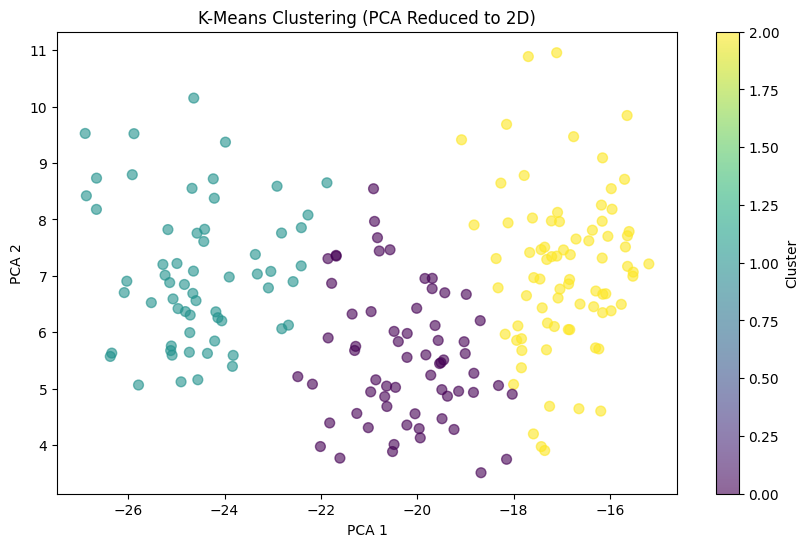

In [ ]:
import matplotlib.pyplot as plt
from pyspark.ml.feature import PCA

# Apply PCA to reduce to 2 dimensions
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(kmeansPredictions)
pca_result = pca_model.transform(kmeansPredictions)

# Extract PCA features for plotting
pca_df = pca_result.select("pca_features", "prediction")
pca_df = pca_df.toPandas()
pca_df["x"] = pca_df["pca_features"].apply(lambda x: x[0])
pca_df["y"] = pca_df["pca_features"].apply(lambda x: x[1])

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(pca_df["x"], pca_df["y"], c=pca_df["prediction"], cmap="viridis", s=50, alpha=0.6)
plt.title("K-Means Clustering (PCA Reduced to 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.show()


In [ ]:
spark.stop()